**Integrantes**:
    
Arianne Macena <br>
Otávio Kamel <br>

Professor:

Paulo Salgado

**Dataset**: https://www.kaggle.com/msambare/fer2013

**Comentário**:

Professor, quando rodamos antes da apresentação, o código rodou direito, inclusive tiramos prints do código e resultados para colocar nos slides.<br>
Quando fomos rodar novamente o notebook para deixar as células com outputs prontos e organizadas para você, o GridSearch apresentou um erro que não conseguimos resolver. Tentamos bastante, mas ele está dando algum erro que tínhamos corrigido, e sem mudar o código, voltou a aparecer.

# Download dataset

In [1]:
# """
#   https://www.kaggle.com/general/74235
#   No arquivo "kaggle.json" vai conter seu username e API Token do Kaggle.
#   Esse método foi utilizado pra ficar mais fácil o download via Colab.
#   Esses passos podem ser pulados e o arquivo zip adicionando diretamente ao Colab.
# """
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !cat ~/.kaggle/kaggle.json 
# !chmod 600 ~/.kaggle/kaggle.json

In [2]:
# !kaggle datasets download msambare/fer2013

In [3]:
# !unzip fer2013.zip

In [4]:
import os, os.path

print("Quantidade de imagens de treinamento: ", sum(len(files) for _, _, files in os.walk(r'train')))

Quantidade de imagens de treinamento:  28709


In [5]:
print("Quantidade de imagens de teste: ", sum(len(files) for _, _, files in os.walk(r'test')))

Quantidade de imagens de teste:  7178


## Split into train/val/test folders

In [6]:
# !mkdir input

In [7]:
# !cp -a train/. input

In [8]:
# !cp -a test/. input

In [9]:
print("Quantidade total de imagens: ", sum(len(files) for _, _, files in os.walk(r'input')))

Quantidade total de imagens:  35887


In [10]:
# !pip install split-folders tqdm

In [11]:
import splitfolders 

# Porcentagens de cada conjunto de dados na variável "ratio" (train/val/test)
splitfolders.ratio("input", output="output", seed=1337, ratio=(.5, .25, .25), group_prefix=None) # default values

Copying files: 35887 files [04:40, 128.13 files/s]


In [110]:
print("Quantidade atualizada de imagens de treinamento: ", sum(len(files) for _, _, files in os.walk(r'output/train')))
print("Quantidade atualizada de imagens de validação: ", sum(len(files) for _, _, files in os.walk(r'output/val')))
print("Quantidade atualizada de imagens de teste: ", sum(len(files) for _, _, files in os.walk(r'output/test')))

Quantidade atualizada de imagens de treinamento:  17941
Quantidade atualizada de imagens de validação:  8969
Quantidade atualizada de imagens de teste:  8977


# Dataset visualization

In [13]:
import matplotlib.pyplot as plt
import os

In [14]:
train_path = 'output/train'
val_path = 'output/val'
test_path = 'output/test'

In [15]:
def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]
  
    plt.figure(figsize=(10, 10))
  
    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)
    
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap='gray')

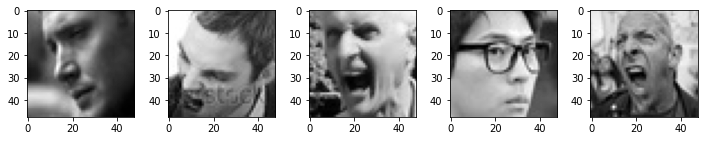

In [16]:
plot_images(train_path+'/angry')

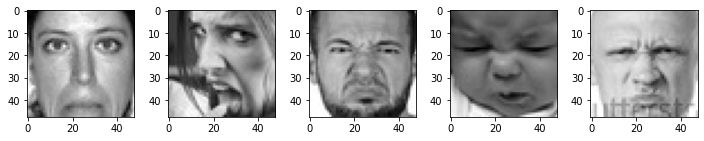

In [17]:
plot_images(train_path+'/disgust')

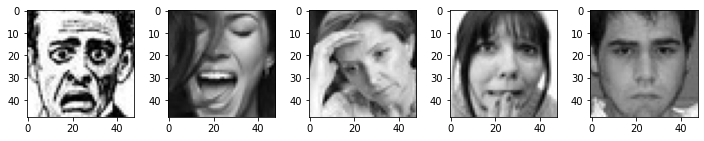

In [18]:
plot_images(train_path+'/fear')

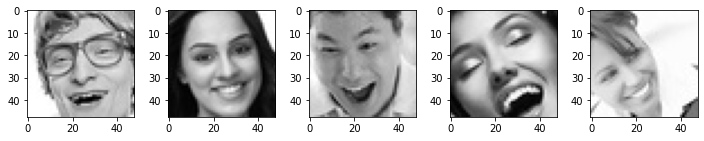

In [19]:
plot_images(train_path+'/happy')

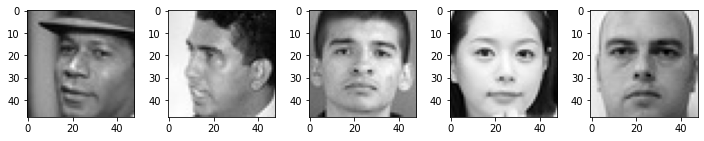

In [20]:
plot_images(train_path+'/neutral')

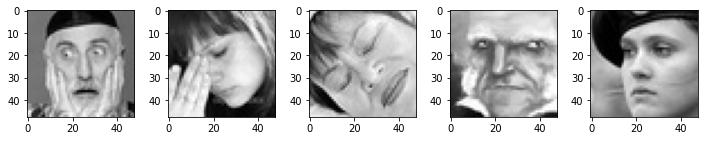

In [21]:
plot_images(train_path+'/sad')

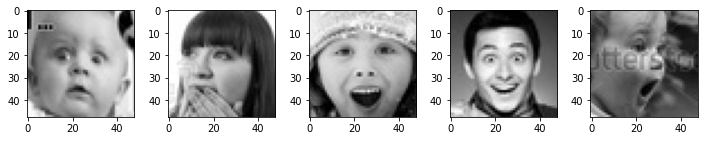

In [22]:
plot_images(train_path+'/surprise')

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import models, layers, regularizers
from sklearn.metrics import classification_report

In [24]:
emotion_labels = sorted(os.listdir(train_path))
print(emotion_labels)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


# Split sets

In [25]:
"""
The batch size defines the number of samples that will be propagated through the network.
"""
batch_size = 64 # samples usados a cada iteração
target_size = (48,48)

"""
The image data has values between 0-255, which we want to scale between 0-1, so we divide by 255.
"""
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)
test_datagen   = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=target_size,
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=True)

val_generator = val_datagen.flow_from_directory(
        val_path,
        target_size=target_size,
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=False)

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=target_size,
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=False)

Found 17941 images belonging to 7 classes.
Found 8969 images belonging to 7 classes.
Found 8977 images belonging to 7 classes.


In [111]:
X_train, y_train = next(train_generator)
X_val, y_val = next(val_generator)
X_test, y_test = next(test_generator)

In [112]:
test_labels = test_generator.classes
print(test_labels)
print(test_labels.shape)

[0 0 0 ... 6 6 6]
(8977,)


# Model

https://www.kaggle.com/kenlin8928/fer2013-cnn/notebook

https://towardsdatascience.com/in-depth-machine-learning-image-classification-with-tensorflow-2-0-a76526b32af8

In [113]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import time
from tensorflow.python.client import device_lib
from tensorflow.keras import layers
from tensorflow.keras import activations

In [114]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [115]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16366390607381810264,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6934691840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 830630160721648636
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:0a:00.0, compute capability: 6.1"]

In [116]:
input_shape = (48,48,1) # img_rows, img_colums, color_channels
num_classes = 7

## Initial MLP

### Structure

In [117]:
def buildMLP(has_dropout, qtd_layers, neurons):
    model = models.Sequential()
    
    model.add(layers.Dense(neurons[0], input_shape=input_shape))
    model.add(layers.Activation('relu'))
    if(has_dropout[0] > 0):
      model.add(layers.Dropout(has_dropout[0]))

    for i in range(1, qtd_layers):
      model.add(layers.Dense(neurons[i]))
      model.add(layers.Activation('relu'))
      if(has_dropout[i] > 0):
        model.add(layers.Dropout(has_dropout[i]))

    model.add(layers.Flatten())
    
    model.add(layers.Dense(num_classes))
    model.add(layers.Activation('softmax'))

    # model.summary()

    # tf.keras.utils.plot_model(
    #     model,
    #     show_shapes=True,
    #     show_layer_names=True,
    # )

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
    
    return model

In [118]:
model_test_mlp = buildMLP([0, 0], 1, [16, 16])

In [119]:
model_test_mlp.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 48, 48, 16)        32        
_________________________________________________________________
activation_18 (Activation)   (None, 48, 48, 16)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 36864)             0         
_________________________________________________________________
dense_23 (Dense)             (None, 7)                 258055    
_________________________________________________________________
activation_19 (Activation)   (None, 7)                 0         
Total params: 258,087
Trainable params: 258,087
Non-trainable params: 0
_________________________________________________________________


In [120]:
tf.keras.utils.plot_model(
    model_test_mlp,
    show_shapes=True,
    show_layer_names=True,
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


### Train

In [121]:
num_epochs = 100
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VAL   = val_generator.n//val_generator.batch_size
print(num_epochs, STEP_SIZE_TRAIN, STEP_SIZE_VAL)

100 280 140


In [42]:
history_test_mlp = model_test_mlp.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=num_epochs, verbose=1, validation_data=val_generator, validation_steps=STEP_SIZE_VAL)

Epoch 1/100
280/280 [==============================] - 174s 617ms/step - loss: 1.7957 - accuracy: 0.2910 - val_loss: 1.7106 - val_accuracy: 0.3373
Epoch 2/100
280/280 [==============================] - 8s 29ms/step - loss: 1.6785 - accuracy: 0.3438 - val_loss: 1.6759 - val_accuracy: 0.3479
Epoch 3/100
280/280 [==============================] - 8s 29ms/step - loss: 1.6684 - accuracy: 0.3508 - val_loss: 1.6675 - val_accuracy: 0.3506
Epoch 4/100
280/280 [==============================] - 8s 29ms/step - loss: 1.6375 - accuracy: 0.3688 - val_loss: 1.6751 - val_accuracy: 0.3547
Epoch 5/100
280/280 [==============================] - 8s 29ms/step - loss: 1.6272 - accuracy: 0.3724 - val_loss: 1.6394 - val_accuracy: 0.3609
Epoch 6/100
280/280 [==============================] - 8s 29ms/step - loss: 1.6073 - accuracy: 0.3810 - val_loss: 1.6582 - val_accuracy: 0.3472
Epoch 7/100
280/280 [==============================] - 8s 29ms/step - loss: 1.6005 - accuracy: 0.3861 - val_loss: 1.6319 - val_accura

#### Test

In [43]:
test_generator.reset()

predict_test = model_test_mlp.predict(test_generator)
print(predict_test.shape)

(8977, 7)


In [44]:
y_pred_test = np.argmax(predict_test, axis=-1)
print(y_pred_test)
print(y_pred_test.shape)

[0 2 6 ... 5 6 6]
(8977,)


In [50]:
print(classification_report(test_labels, y_pred_test))

              precision    recall  f1-score   support

           0       0.30      0.16      0.21      1239
           1       0.36      0.17      0.23       138
           2       0.22      0.22      0.22      1281
           3       0.50      0.47      0.49      2248
           4       0.29      0.47      0.36      1550
           5       0.32      0.21      0.26      1520
           6       0.41      0.52      0.46      1001

    accuracy                           0.35      8977
   macro avg       0.34      0.32      0.32      8977
weighted avg       0.35      0.35      0.34      8977



In [51]:
test_generator.reset()

scores = model_test_mlp.evaluate(test_generator)
print("%s%s: %.2f%%" % ("evaluate ", model_test_mlp.metrics_names[1], scores[1]*100))

141/141 [==============================] - 3s 20ms/step - loss: 2.0678 - accuracy: 0.3515
evaluate accuracy: 35.15%


## Initial CNN

### Structure

In [54]:
def buildCNN(neurons, qtd_layers, dropout_value):
    model = models.Sequential()

    model.add(layers.Conv2D(neurons[0], kernel_size=(3, 3), activation=activations.relu, padding='same', input_shape=input_shape)) #, data_format='channels_last', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    for i in range(1, qtd_layers + 1):
      model.add(layers.Conv2D(neurons[i], kernel_size=(3, 3), activation=activations.relu, padding='same'))
      model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(layers.Flatten())

    if(dropout_value > 0):
      model.add(layers.Dropout(dropout_value))

    model.add(layers.Dense(num_classes, activation=activations.softmax))

    # model.summary()

    # tf.keras.utils.plot_model(
    #     model,
    #     show_shapes=True,
    #     show_layer_names=True,
    # )

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
    
    return model

In [55]:
model_test_cnn = buildCNN([32, 32], 1, 0)

In [56]:
model_test_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 32263     
Total params: 41,831
Trainable params: 41,831
Non-trainable params: 0
__________________________________________________

In [57]:
tf.keras.utils.plot_model(
    model_test_cnn,
    show_shapes=True,
    show_layer_names=True,
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


### Train

In [58]:
history_test_cnn = model_test_cnn.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=num_epochs, verbose=1, validation_data=val_generator, validation_steps=STEP_SIZE_VAL)

Epoch 1/100
280/280 [==============================] - 12s 32ms/step - loss: 1.7263 - accuracy: 0.3124 - val_loss: 1.6267 - val_accuracy: 0.3762
Epoch 2/100
280/280 [==============================] - 8s 30ms/step - loss: 1.5452 - accuracy: 0.4082 - val_loss: 1.5073 - val_accuracy: 0.4355
Epoch 3/100
280/280 [==============================] - 9s 31ms/step - loss: 1.4452 - accuracy: 0.4526 - val_loss: 1.4479 - val_accuracy: 0.4569
Epoch 4/100
280/280 [==============================] - 9s 31ms/step - loss: 1.3752 - accuracy: 0.4810 - val_loss: 1.4156 - val_accuracy: 0.4585
Epoch 5/100
280/280 [==============================] - 10s 36ms/step - loss: 1.3285 - accuracy: 0.5022 - val_loss: 1.4004 - val_accuracy: 0.4731
Epoch 6/100
280/280 [==============================] - 10s 34ms/step - loss: 1.2816 - accuracy: 0.5204 - val_loss: 1.4132 - val_accuracy: 0.4728
Epoch 7/100
280/280 [==============================] - 9s 33ms/step - loss: 1.2388 - accuracy: 0.5347 - val_loss: 1.3724 - val_accura

### Test

In [59]:
test_generator.reset()

predict_test_cnn = model_test_cnn.predict(test_generator)
print(predict_test_cnn.shape)

(8977, 7)


In [60]:
y_pred_test_cnn = np.argmax(predict_test_cnn, axis=-1)
print(y_pred_test_cnn)
print(y_pred_test_cnn.shape)

[3 5 5 ... 6 3 6]
(8977,)


In [61]:
print(classification_report(test_labels, y_pred_test_cnn))

              precision    recall  f1-score   support

           0       0.33      0.34      0.34      1239
           1       0.54      0.33      0.41       138
           2       0.33      0.26      0.29      1281
           3       0.62      0.66      0.64      2248
           4       0.40      0.42      0.41      1550
           5       0.34      0.32      0.33      1520
           6       0.56      0.64      0.60      1001

    accuracy                           0.45      8977
   macro avg       0.45      0.43      0.43      8977
weighted avg       0.45      0.45      0.45      8977



In [62]:
test_generator.reset()

scores = model_test_cnn.evaluate(test_generator)
print("%s%s: %.2f%%" % ("evaluate ", model_test_cnn.metrics_names[1], scores[1]*100))

141/141 [==============================] - 3s 19ms/step - loss: 5.2192 - accuracy: 0.4545
evaluate accuracy: 45.45%


# GridSearch

In [63]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [64]:
num_epochs = 100

In [122]:
modelMLP = KerasClassifier(build_fn=buildMLP, verbose=0)
modelCNN = KerasClassifier(build_fn=buildCNN, verbose=0)

# mlp -> has_dropout, qtd_layers, neurons
params = {
            'epochs': [300],
            'neurons': [[256, 16, 32, 64], [32, 64, 128, 256], [16, 32, 64, 128]],
            'has_dropout': [[0, 0, 0, 0], [0.2, 0.2, 0.2, 0.2], [0.5, 0.5, 0.5, 0.5]],
            'qtd_layers': [2,  3]
          }

# cnn -> neurons, qtd_layers, dropout_value
paramsCNN = {
              'epochs': [300],
              'qtd_layers': [2, 3, 4],
              'dropout_value': [0, 0.2, 0.5],
              'neurons': [[256, 32, 64, 128, 64], [32, 64, 128, 512, 512], [32, 32, 64, 64, 128]]
          }

In [66]:
y_train_single = np.argmax(y_train, axis = 1)
print(y_train_single)

[3 4 5 3 5 6 3 4 6 5 3 3 3 2 4 0 3 2 2 6 4 4 5 2 4 5 4 6 5 5 4 6 4 3 3 3 3
 3 0 2 2 0 3 5 5 5 3 4 6 2 3 3 4 0 4 5 0 4 3 5 0 2 0 5]


In [67]:
print(X_train.shape)
print(y_train_single.shape)

(64, 48, 48, 1)
(64,)


## MLP

In [124]:
grid_search = GridSearchCV(estimator = modelMLP,
                           param_grid = params,
                           scoring = 'accuracy',
                           cv = 3, 
                           verbose = 1,
                           error_score="raise")

grid_result = grid_search.fit(X_train, y_train_single)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


ValueError: in user code:

    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:796 train_step
        loss = self.compiled_loss(
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\losses.py:155 __call__
        losses = call_fn(y_true, y_pred)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\losses.py:259 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\losses.py:1643 categorical_crossentropy
        return backend.categorical_crossentropy(
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\backend.py:4862 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 6) and (None, 7) are incompatible


In [ ]:
print("Melhor acurácia foi de %f usando %s" % (grid_result.best_score_, grid_result.best_params_))

### Structure

In [69]:
best_modelMLP = buildMLP(grid_result.best_params_['has_dropout'], grid_result.best_params_['qtd_layers'], grid_result.best_params_['neurons'])

NameError: name 'grid_result' is not defined

In [70]:
best_modelMLP.summary()

NameError: name 'best_modelMLP' is not defined

In [ ]:
!pip install pydot
!pip install graphviz

In [71]:
tf.keras.utils.plot_model(
    best_modelMLP,
    show_shapes=True,
    show_layer_names=True,
)

NameError: name 'best_modelMLP' is not defined

### Train

In [72]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VAL   = val_generator.n//val_generator.batch_size
print(num_epochs, STEP_SIZE_TRAIN, STEP_SIZE_VAL)

100 280 140


In [73]:
historyMLP_gs = best_modelMLP.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=num_epochs, verbose=1, validation_data=val_generator, validation_steps=STEP_SIZE_VAL)

NameError: name 'best_modelMLP' is not defined

### Test

In [74]:
test_generator.reset()

predict_mlp_gs = best_modelMLP.predict(test_generator)
print(predict_mlp_gs.shape)

NameError: name 'best_modelMLP' is not defined

In [75]:
y_pred_mlp_gs = np.argmax(predict_mlp_gs, axis=-1)
print(y_pred_mlp_gs)
print(y_pred_mlp_gs.shape)

NameError: name 'predict_mlp_gs' is not defined

In [76]:
print(classification_report(test_labels, y_pred_mlp_gs))

NameError: name 'y_pred_mlp_gs' is not defined

## CNN

In [77]:
grid_search_cnn = GridSearchCV(estimator = modelCNN,
                           param_grid = paramsCNN,
                           scoring = 'accuracy',
                           cv = 3, 
                           verbose = 1,
                           error_score="raise")

grid_result_cnn = grid_search_cnn.fit(X_train, y_train_single)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


ValueError: in user code:

    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\engine\training.py:796 train_step
        loss = self.compiled_loss(
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\losses.py:155 __call__
        losses = call_fn(y_true, y_pred)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\losses.py:259 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\losses.py:1643 categorical_crossentropy
        return backend.categorical_crossentropy(
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\keras\backend.py:4862 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\ProgramData\Anaconda3\envs\tfgpu\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 6) and (None, 7) are incompatible


In [78]:
print("Melhor acurácia foi de %f usando %s" % (grid_result_cnn.best_score_, grid_result_cnn.best_params_))

NameError: name 'grid_result_cnn' is not defined

### Structure

In [79]:
best_modelCNN = buildCNN(grid_result_cnn.best_params_['neurons'], grid_result_cnn.best_params_['qtd_layers'], grid_result_cnn.best_params_['dropout_value'])

NameError: name 'grid_result_cnn' is not defined

In [80]:
best_modelCNN.summary()

NameError: name 'best_modelCNN' is not defined

In [ ]:
tf.keras.utils.plot_model(
    best_modelCNN,
    show_shapes=True,
    show_layer_names=True,
)

### Train

In [ ]:
historyCNN_gs = best_modelCNN.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=num_epochs, verbose=1, validation_data=val_generator, validation_steps=STEP_SIZE_VAL)

### Test

In [ ]:
test_generator.reset()

predict_cnn_gs = best_modelCNN.predict(test_generator)
print(predict_cnn_gs.shape)

In [ ]:
y_pred_cnn_gs = np.argmax(predict_cnn_gs, axis=-1)
print(y_pred_cnn_gs)
print(y_pred_cnn_gs.shape)

In [ ]:
print(classification_report(test_labels, y_pred_cnn_gs))

In [ ]:
test_generator.reset()

scores = best_modelCNN.evaluate(test_generator)
print("%s%s: %.2f%%" % ("evaluate ", best_modelCNN.metrics_names[1], scores[1]*100))

# PSO

In [83]:
!pip install pyswarms
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO

In [84]:
y_val_single = np.argmax(y_val, axis = 1)
print(y_val_single)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [85]:
options = {'c1': 0.3, 'c2': 0.3, 'w': 0.5}

## MLP

In [86]:
"""
  Hiperparâmetros para MLP
  {'epochs': 300, 'has_dropout': [0.2, 0.2, 0.2, 0.2], 'neurons': [32, 64, 128, 256], 'qtd_layers': 2}
  
  0: valores min/max de quantidade de hidden layers (1 à 3)
  1: valores min/max de valor dropout da primeira layer (0 à 0.5)
  2: valores min/max de valor dropout da primeira hidden layer (0 à 0.5)
  3: valores min/max de valor dropout da segunda hidden layer (0 à 0.5)
  4: valores min/max de valor dropout da terceira hidden layer (0 à 0.5)
  5: valores min/max de neurônios da primeira layer (8 a 128)
  6: valores min/max de neurônios da primeira hidden layer (8 a 128)
  7: valores min/max de neurônios da segunda hidden layer (8 a 128)
  8: valores min/max de neurônios da terceira hidden layer (8 a 128)

"""

min_bound_mlp = np.array([1, 0, 0, 0, 0, 8, 8, 8, 8])
max_bound_mlp = np.array([3, 0.5, 0.5, 0.5, 0.5, 128, 128, 128, 128])
bounds_mlp = (min_bound_mlp, max_bound_mlp)
print(bounds_mlp)

(array([1, 0, 0, 0, 0, 8, 8, 8, 8]), array([  3. ,   0.5,   0.5,   0.5,   0.5, 128. , 128. , 128. , 128. ]))


In [87]:
def fitnessMLP(bound_values):

    # (has_dropout, qtd_layers, neurons)
    model = buildMLP(
      [int(bound_values[0, 1]), int(bound_values[0, 2]), int(bound_values[0, 3]), int(bound_values[0, 4])], 
      int(bound_values[0, 0]),
      [int(bound_values[0, 5]), int(bound_values[0, 6]), int(bound_values[0, 7]), int(bound_values[0, 8])])
    
    model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=num_epochs, verbose=1, validation_data=val_generator, validation_steps=STEP_SIZE_VAL)
    
    val_generator.reset()

    predictions = model.predict(val_generator)
    y_pred = np.argmax(predictions, axis=-1)
    val_labels = val_generator.classes

    acc = classification_report(val_labels, y_pred, output_dict=True)['accuracy']

    return 1-acc 

In [88]:
optimizerMLP = GlobalBestPSO(n_particles=10, dimensions=len(min_bound_mlp), options=options, bounds=bounds_mlp)

final_best_cost_mlp, final_best_pos_mlp = optimizerMLP.optimize(fitnessMLP, iters=1)

2021-11-08 17:01:27,783 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.3, 'c2': 0.3, 'w': 0.5}
pyswarms.single.global_best:   0%|                                                                                 |0/1

Epoch 1/100
280/280 [==============================] - 10s 34ms/step - loss: 2.0206 - accuracy: 0.2876 - val_loss: 1.7423 - val_accuracy: 0.3250
Epoch 2/100
280/280 [==============================] - 8s 30ms/step - loss: 1.6927 - accuracy: 0.3420 - val_loss: 1.7364 - val_accuracy: 0.3182
Epoch 3/100
280/280 [==============================] - 8s 29ms/step - loss: 1.6639 - accuracy: 0.3523 - val_loss: 1.6776 - val_accuracy: 0.3471
Epoch 4/100
280/280 [==============================] - 8s 29ms/step - loss: 1.6421 - accuracy: 0.3646 - val_loss: 1.6720 - val_accuracy: 0.3482
Epoch 5/100
280/280 [==============================] - 8s 30ms/step - loss: 1.6143 - accuracy: 0.3746 - val_loss: 1.6484 - val_accuracy: 0.3664
Epoch 6/100
280/280 [==============================] - 8s 29ms/step - loss: 1.5981 - accuracy: 0.3817 - val_loss: 1.6995 - val_accuracy: 0.3484
Epoch 7/100
280/280 [==============================] - 8s 30ms/step - loss: 1.5886 - accuracy: 0.3866 - val_loss: 1.6736 - val_accuracy

pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████████|1/1, best_cost=0.673
2021-11-08 17:19:36,266 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6733192106143383, best pos: [1.76302883e+00 4.53828629e-01 5.65761589e-04 4.38248449e-01
 2.22173670e-01 1.20890829e+02 2.85707346e+01 6.67652687e+01
 7.39086296e+01]


In [89]:
print(final_best_pos_mlp)

[1.76302883e+00 4.53828629e-01 5.65761589e-04 4.38248449e-01
 2.22173670e-01 1.20890829e+02 2.85707346e+01 6.67652687e+01
 7.39086296e+01]


### Structure

In [90]:
best_modelMLP_PSO = buildMLP(
        [int(final_best_pos_mlp[2]), int(final_best_pos_mlp[3]), int(final_best_pos_mlp[4]), int(final_best_pos_mlp[5]), int(final_best_pos_mlp[6])], 
        int(final_best_pos_mlp[1]), 
        [int(final_best_pos_mlp[5]), int(final_best_pos_mlp[6]), int(final_best_pos_mlp[7]), int(final_best_pos_mlp[8])])

In [91]:
best_modelMLP_PSO.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 48, 48, 120)       240       
_________________________________________________________________
activation_13 (Activation)   (None, 48, 48, 120)       0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 276480)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 7)                 1935367   
_________________________________________________________________
activation_14 (Activation)   (None, 7)                 0         
Total params: 1,935,607
Trainable params: 1,935,607
Non-trainable params: 0
_________________________________________________________________


In [92]:
tf.keras.utils.plot_model(
    best_modelMLP_PSO,
    show_shapes=True,
    show_layer_names=True,
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


### Train

In [93]:
historyMLP_gs = best_modelMLP_PSO.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=num_epochs, verbose=1, validation_data=val_generator, validation_steps=STEP_SIZE_VAL)

Epoch 1/100
280/280 [==============================] - 9s 30ms/step - loss: 1.8777 - accuracy: 0.2870 - val_loss: 1.7097 - val_accuracy: 0.3296
Epoch 2/100
280/280 [==============================] - 103s 367ms/step - loss: 1.6833 - accuracy: 0.3449 - val_loss: 1.6683 - val_accuracy: 0.3433
Epoch 3/100
280/280 [==============================] - 24s 85ms/step - loss: 1.6599 - accuracy: 0.3524 - val_loss: 1.6418 - val_accuracy: 0.3584
Epoch 4/100
280/280 [==============================] - 9s 31ms/step - loss: 1.6288 - accuracy: 0.3712 - val_loss: 1.6527 - val_accuracy: 0.3617
Epoch 5/100
280/280 [==============================] - 8s 29ms/step - loss: 1.6191 - accuracy: 0.3765 - val_loss: 1.6305 - val_accuracy: 0.3606
Epoch 6/100
280/280 [==============================] - 8s 29ms/step - loss: 1.5999 - accuracy: 0.3839 - val_loss: 1.6284 - val_accuracy: 0.3629
Epoch 7/100
280/280 [==============================] - 8s 29ms/step - loss: 1.5841 - accuracy: 0.3917 - val_loss: 1.6739 - val_accur

### Test

In [94]:
test_generator.reset()

predict_mlp_pso = best_modelMLP_PSO.predict(test_generator)
print(predict_mlp_pso.shape)

(8977, 7)


In [95]:
y_pred_mlp_pso = np.argmax(predict_mlp_pso, axis=-1)
print(y_pred_mlp_pso)
print(y_pred_mlp_pso.shape)

[3 4 6 ... 5 0 6]
(8977,)


In [96]:
print(classification_report(test_labels, y_pred_mlp_pso))

              precision    recall  f1-score   support

           0       0.29      0.13      0.18      1239
           1       0.25      0.18      0.21       138
           2       0.22      0.26      0.24      1281
           3       0.45      0.52      0.48      2248
           4       0.30      0.32      0.31      1550
           5       0.26      0.33      0.30      1520
           6       0.51      0.34      0.41      1001

    accuracy                           0.34      8977
   macro avg       0.33      0.30      0.30      8977
weighted avg       0.34      0.34      0.33      8977



## CNN

In [97]:
"""
  Hiperparâmetros para CNN
  {'dropout_value': 0, 'epochs': 300, 'neurons': [32, 64, 128, 512, 512], 'qtd_layers': 2}

  0: valores min/max de dropout (0 à 0.5)
  1: valores min/max de quantidade de hidden layers (1 à 4)
  2: valores min/max de neurônios da primeira layer (8 a 128)
  3: valores min/max de neurônios da primeira hidden layer (8 a 128)
  4: valores min/max de neurônios da segunda hidden layer (8 a 128)
  5: valores min/max de neurônios da terceira hidden layer (8 a 128)
  6: valores min/max de neurônios da quarta hidden layer (8 a 128)

"""

min_bound_cnn = np.array([0, 1, 8, 8, 8, 8, 8])
max_bound_cnn = np.array([0.5, 4, 128, 128, 128, 128, 128])
bounds_cnn = (min_bound_cnn, max_bound_cnn)
print(bounds_cnn)

(array([0, 1, 8, 8, 8, 8, 8]), array([  0.5,   4. , 128. , 128. , 128. , 128. , 128. ]))


In [98]:
def fitnessCNN(bound_values):
    # (neurons, qtd_layers, dropout_value)
    model = buildCNN(
        [int(bound_values[0, 2]), int(bound_values[0, 3]), int(bound_values[0, 4]), int(bound_values[0, 5]), int(bound_values[0, 6])], 
        int(bound_values[0, 1]), 
        int(bound_values[0, 0]))
    
    model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=num_epochs, verbose=1, validation_data=val_generator, validation_steps=STEP_SIZE_VAL)
    
    val_generator.reset()

    predictions = model.predict(val_generator)
    y_pred = np.argmax(predictions, axis=-1)
    val_labels = val_generator.classes

    acc = classification_report(val_labels, y_pred, output_dict=True)['accuracy']

    return 1-acc 

In [99]:
optimizerCNN = GlobalBestPSO(n_particles=10, dimensions=len(min_bound_cnn), options=options, bounds=bounds_cnn)

final_best_cost_cnn, final_best_pos_cnn = optimizerCNN.optimize(fitnessCNN, iters=1)

2021-11-08 17:39:04,220 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.3, 'c2': 0.3, 'w': 0.5}
pyswarms.single.global_best:   0%|                                                                                 |0/1

Epoch 1/100
280/280 [==============================] - 9s 31ms/step - loss: 1.6919 - accuracy: 0.3294 - val_loss: 1.6126 - val_accuracy: 0.3633
Epoch 2/100
280/280 [==============================] - 8s 30ms/step - loss: 1.5302 - accuracy: 0.4138 - val_loss: 1.4934 - val_accuracy: 0.4336
Epoch 3/100
280/280 [==============================] - 8s 30ms/step - loss: 1.4339 - accuracy: 0.4568 - val_loss: 1.4301 - val_accuracy: 0.4557
Epoch 4/100
280/280 [==============================] - 8s 30ms/step - loss: 1.3489 - accuracy: 0.4907 - val_loss: 1.4020 - val_accuracy: 0.4750
Epoch 5/100
280/280 [==============================] - 8s 30ms/step - loss: 1.2898 - accuracy: 0.5186 - val_loss: 1.3898 - val_accuracy: 0.4795
Epoch 6/100
280/280 [==============================] - 8s 30ms/step - loss: 1.2303 - accuracy: 0.5395 - val_loss: 1.3828 - val_accuracy: 0.4805
Epoch 7/100
280/280 [==============================] - 8s 30ms/step - loss: 1.1768 - accuracy: 0.5627 - val_loss: 1.3709 - val_accuracy:

pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████████|1/1, best_cost=0.534
2021-11-08 17:53:14,970 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5339502731631174, best pos: [  0.19174747   1.47706454  21.63183083  69.93543288  60.39694315
 120.08598064 103.91813565]


In [100]:
print(final_best_pos_cnn)

[  0.19174747   1.47706454  21.63183083  69.93543288  60.39694315
 120.08598064 103.91813565]


### Structure

In [101]:
best_modelCNN_PSO = buildCNN(
        [int(final_best_pos_cnn[2]), int(final_best_pos_cnn[3]), int(final_best_pos_cnn[4]), int(final_best_pos_cnn[5]), int(final_best_pos_cnn[6])], 
        int(final_best_pos_cnn[1]), 
        int(final_best_pos_cnn[0]))

In [102]:
best_modelCNN_PSO.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 48, 48, 21)        210       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 21)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 69)        13110     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 69)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 9936)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 7)                 69559     
Total params: 82,879
Trainable params: 82,879
Non-trainable params: 0
__________________________________________________

In [103]:
tf.keras.utils.plot_model(
    best_modelCNN_PSO,
    show_shapes=True,
    show_layer_names=True,
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


### Train

In [104]:
historyCNN_gs = best_modelCNN_PSO.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=num_epochs, verbose=1, validation_data=val_generator, validation_steps=STEP_SIZE_VAL)

Epoch 1/100
280/280 [==============================] - 9s 29ms/step - loss: 1.7101 - accuracy: 0.3195 - val_loss: 1.6207 - val_accuracy: 0.3682
Epoch 2/100
280/280 [==============================] - 8s 29ms/step - loss: 1.5096 - accuracy: 0.4239 - val_loss: 1.4724 - val_accuracy: 0.4388
Epoch 3/100
280/280 [==============================] - 8s 29ms/step - loss: 1.4059 - accuracy: 0.4686 - val_loss: 1.4278 - val_accuracy: 0.4588
Epoch 4/100
280/280 [==============================] - 8s 29ms/step - loss: 1.3266 - accuracy: 0.5001 - val_loss: 1.3965 - val_accuracy: 0.4721
Epoch 5/100
280/280 [==============================] - 8s 29ms/step - loss: 1.2655 - accuracy: 0.5254 - val_loss: 1.3682 - val_accuracy: 0.4894
Epoch 6/100
280/280 [==============================] - 8s 30ms/step - loss: 1.2066 - accuracy: 0.5496 - val_loss: 1.3567 - val_accuracy: 0.4949
Epoch 7/100
280/280 [==============================] - 8s 29ms/step - loss: 1.1516 - accuracy: 0.5705 - val_loss: 1.3601 - val_accuracy:

### Test

In [105]:
test_generator.reset()

predict_cnn_pso = best_modelCNN_PSO.predict(test_generator)
print(predict_cnn_pso.shape)

(8977, 7)


In [106]:
y_pred_cnn_pso = np.argmax(predict_cnn_pso, axis=-1)
print(y_pred_cnn_pso)
print(y_pred_cnn_pso.shape)

[3 4 0 ... 6 6 6]
(8977,)


In [107]:
print(classification_report(test_labels, y_pred_cnn_pso))

              precision    recall  f1-score   support

           0       0.35      0.39      0.37      1239
           1       0.45      0.33      0.38       138
           2       0.32      0.33      0.33      1281
           3       0.66      0.68      0.67      2248
           4       0.43      0.42      0.42      1550
           5       0.34      0.33      0.33      1520
           6       0.65      0.59      0.62      1001

    accuracy                           0.47      8977
   macro avg       0.46      0.44      0.45      8977
weighted avg       0.47      0.47      0.47      8977

